# Data collection and wrangling

* import libraries, load .csv file, inspect contents
* convert data types to desired types and double check date range of data
* clean up data 
    * delete duplicate rides
    * delete duplicate rides
    * notice and delete TEST rides
    * delete errors
    * create dictionary of {station names: list of station IDs} (rewrite succinctly); I just wanted a unique ID per station for potential later use
    * use this dictionary to create start_id and end_id columns, so each station has a unique ID
    * round latitudes and longitudes
    * deal with missing data
    * add holiday data and some time columns
    * remove some more errors (like bike trips of negative duration) that show up in the data
    * add weather data (just from weather station USC00111577 for now)
    * save to pickle file for exploratory data analysis

What we’re going to predict is number of departing rides per hour at each starting station (or coordinate pair). So after we make some graphs, data should be pivoted to be organized by **start_id** and then preprocessed for an LSTM.

# 1. Importing libraries, loading the data, and taking a first look

In [1]:
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import json
import requests

In [2]:
all_files = glob.glob('data/raw/*.csv')

In [3]:
df_list = []
for file in all_files:
    df = pd.read_csv(file)
    df_list.append(df)   

trips = pd.concat(df_list, ignore_index=True)

In [4]:
trips.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,7569BC890583FCD7,classic_bike,2025-01-21 17:23:54.538,2025-01-21 17:37:52.015,Wacker Dr & Washington St,KA1503000072,McClurg Ct & Ohio St,TA1306000029,41.883143,-87.637242,41.892592,-87.617289,member
1,013609308856B7FC,electric_bike,2025-01-11 15:44:06.795,2025-01-11 15:49:11.139,Halsted St & Wrightwood Ave,TA1309000061,Racine Ave & Belmont Ave,TA1308000019,41.929147,-87.649153,41.939743,-87.658865,member
2,EACACD3CE0607C0D,classic_bike,2025-01-02 15:16:27.730,2025-01-02 15:28:03.230,Southport Ave & Waveland Ave,13235,Broadway & Cornelia Ave,13278,41.948226,-87.664071,41.945529,-87.646439,member
3,EAA2485BA64710D3,classic_bike,2025-01-23 08:49:05.814,2025-01-23 08:52:40.047,Southport Ave & Waveland Ave,13235,Southport Ave & Roscoe St,13071,41.948226,-87.664071,41.943739,-87.664020,member
4,7F8BE2471C7F746B,electric_bike,2025-01-16 08:38:32.338,2025-01-16 08:41:06.767,Southport Ave & Waveland Ave,13235,Southport Ave & Roscoe St,13071,41.948226,-87.664071,41.943739,-87.664020,member


In [5]:
trips.columns

Index(['ride_id', 'rideable_type', 'started_at', 'ended_at',
       'start_station_name', 'start_station_id', 'end_station_name',
       'end_station_id', 'start_lat', 'start_lng', 'end_lat', 'end_lng',
       'member_casual'],
      dtype='object')

In [6]:
trips.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11273028 entries, 0 to 11273027
Data columns (total 13 columns):
 #   Column              Dtype  
---  ------              -----  
 0   ride_id             object 
 1   rideable_type       object 
 2   started_at          object 
 3   ended_at            object 
 4   start_station_name  object 
 5   start_station_id    object 
 6   end_station_name    object 
 7   end_station_id      object 
 8   start_lat           float64
 9   start_lng           float64
 10  end_lat             float64
 11  end_lng             float64
 12  member_casual       object 
dtypes: float64(4), object(9)
memory usage: 1.1+ GB


In [7]:
null_counts = trips.isnull().sum()
print(null_counts)

ride_id                     0
rideable_type               0
started_at                  0
ended_at                    0
start_station_name    2231698
start_station_id      2231698
end_station_name      2317913
end_station_id        2317913
start_lat                   0
start_lng                   0
end_lat                 12645
end_lng                 12645
member_casual               0
dtype: int64


# 2. Converting data types and sorting by date

In [8]:
trips = trips.convert_dtypes()

trips['started_at'] = pd.to_datetime(trips['started_at'], format='ISO8601')
trips['ended_at'] = pd.to_datetime(trips['ended_at'], format='ISO8601')

In [9]:
trips.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11273028 entries, 0 to 11273027
Data columns (total 13 columns):
 #   Column              Dtype         
---  ------              -----         
 0   ride_id             string        
 1   rideable_type       string        
 2   started_at          datetime64[ns]
 3   ended_at            datetime64[ns]
 4   start_station_name  string        
 5   start_station_id    string        
 6   end_station_name    string        
 7   end_station_id      string        
 8   start_lat           Float64       
 9   start_lng           Float64       
 10  end_lat             Float64       
 11  end_lng             Float64       
 12  member_casual       string        
dtypes: Float64(4), datetime64[ns](2), string(7)
memory usage: 1.1 GB


In [10]:
trips_sorted = trips.sort_values(by=['started_at', 'ended_at'])
trips_sorted = trips_sorted.reset_index(drop=True)
trips_sorted.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,6A9D809ABDF70617,electric_bike,2024-01-01 00:00:39,2024-01-01 00:07:56,<NA>,<NA>,Clark St & Wrightwood Ave,TA1305000014,41.95,-87.65,41.929546,-87.643118,member
1,26B9F6E416A68EBA,electric_bike,2024-01-01 00:00:50,2024-01-01 00:04:20,<NA>,<NA>,<NA>,<NA>,41.9,-87.62,41.9,-87.62,casual
2,30EF016A0DF5ECEE,electric_bike,2024-01-01 00:00:52,2024-01-01 00:04:25,<NA>,<NA>,<NA>,<NA>,41.9,-87.62,41.9,-87.62,casual
3,0D9E85F804C85828,electric_bike,2024-01-01 00:00:53,2024-01-01 00:22:30,Clinton St & Madison St,TA1305000032,<NA>,<NA>,41.881909,-87.641296,41.89,-87.62,member
4,56F5C3ED5178C131,classic_bike,2024-01-01 00:01:01,2024-01-01 00:24:12,LaSalle St & Illinois St,13430,Indiana Ave & Roosevelt Rd,SL-005,41.890762,-87.631697,41.867888,-87.623041,member


In [11]:
trips_sorted.tail()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
11273023,E19A4F05BC8F5EC1,classic_bike,2025-11-30 23:38:18.618,2025-11-30 23:47:42.399,Broadway & Waveland Ave,CHI00496,Clarendon Ave & Leland Ave,CHI00365,41.949074,-87.648636,41.967968,-87.650001,member
11273024,D953F4F11B6AD9A3,electric_bike,2025-11-30 23:38:36.019,2025-11-30 23:47:21.560,Clinton St & Roosevelt Rd,CHI00497,Blue Island Ave & 18th St,CHI00443,41.867118,-87.641088,41.857556,-87.661535,casual
11273025,FEFDD786F104FF68,electric_bike,2025-11-30 23:39:22.153,2025-11-30 23:39:58.497,Addison/Wilton Corral,CHI02063,Addison/Wilton Corral,CHI02063,41.947383,-87.653172,41.947383,-87.653172,member
11273026,6982EE63F71148AE,classic_bike,2025-11-30 23:44:44.424,2025-11-30 23:49:24.664,Paulina St & 18th St,CHI00312,Racine Ave & 18th St,CHI00277,41.857901,-87.668745,41.8584,-87.656423,member
11273027,E861A9162489D197,electric_bike,2025-11-30 23:51:43.800,2025-11-30 23:53:31.597,<NA>,<NA>,<NA>,<NA>,41.98,-87.71,41.98,-87.71,casual


# 3. Cleaning up data

First of all, ride_id should be a unique identifier (i.e. there should be no duplicate rides in the data) and we should check for missing data and errors.

In [12]:
len(trips_sorted['ride_id'].unique())

11272817

In [13]:
duplicates_in_id = trips_sorted[trips_sorted['ride_id'].duplicated()]
duplicates_in_id

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
1669283,D739DA08680E8A0B,classic_bike,2024-05-31 01:02:49.582,2024-06-01 02:02:43.407,Columbus Dr & Randolph St,13263,<NA>,<NA>,41.884728,-87.619521,<NA>,<NA>,casual
1669303,2C2CD7C3DCBC3C39,classic_bike,2024-05-31 01:09:43.561,2024-06-01 02:09:36.476,Michigan Ave & 8th St,623,<NA>,<NA>,41.872773,-87.623981,<NA>,<NA>,casual
1669953,73894F50512DDA03,classic_bike,2024-05-31 06:32:22.834,2024-06-01 07:32:01.767,Broadway & Waveland Ave,13325,<NA>,<NA>,41.949074,-87.648636,<NA>,<NA>,casual
1670468,91D1E6CF6EEA5BD8,classic_bike,2024-05-31 07:16:24.189,2024-06-01 08:16:16.121,California Ave & 21st St,13096,<NA>,<NA>,41.853796,-87.695823,<NA>,<NA>,casual
1672640,DBAEDF6D73232242,classic_bike,2024-05-31 09:27:11.855,2024-06-01 10:26:48.871,Wells St & Huron St,TA1306000012,<NA>,<NA>,41.894722,-87.634362,<NA>,<NA>,casual
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1694444,404A6359522B7323,electric_bike,2024-05-31 23:58:52.782,2024-06-01 00:19:50.654,<NA>,<NA>,Morgan St & Polk St,TA1307000130,41.88,-87.64,41.871737,-87.65103,member
1694446,7A3224608C3E5179,electric_bike,2024-05-31 23:59:37.406,2024-06-01 00:06:39.076,Dayton St & North Ave,13058,Sheffield Ave & Wrightwood Ave,TA1309000023,41.910589,-87.649394,41.928712,-87.653833,casual
1694448,710616EF83DFB247,electric_bike,2024-05-31 23:59:47.253,2024-06-01 00:20:16.597,Seeley Ave & Roscoe St,13144,Green St & Madison St,TA1307000120,41.943434,-87.679647,41.881859,-87.649264,member
1694450,A4BCF625862FDDF2,electric_bike,2024-05-31 23:59:56.662,2024-06-01 00:43:58.834,Public Rack - Halsted St & 80th St,887,<NA>,<NA>,41.748306,-87.64411,41.75,-87.6,casual


There are 211 duplicates. What is going on here? Let's look at one:

In [14]:
trips_sorted[trips_sorted['ride_id'] == "2C772EDDDBDEFDA3"]

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
1694193,2C772EDDDBDEFDA3,electric_bike,2024-05-31 23:42:42.000,2024-06-01 00:25:08.000,Dearborn St & Van Buren St,624,DuSable Lake Shore Dr & Monroe St,13300,41.876054,-87.629921,41.880958,-87.616743,casual
1694194,2C772EDDDBDEFDA3,electric_bike,2024-05-31 23:42:42.116,2024-06-01 00:25:08.424,Dearborn St & Van Buren St,624,DuSable Lake Shore Dr & Monroe St,13300,41.876054,-87.629921,41.880958,-87.616743,casual


And another one:

In [15]:
trips_sorted[trips_sorted['ride_id'] == "D55108DEEE45D0E6"]

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
1686960,D55108DEEE45D0E6,classic_bike,2024-05-31 18:21:43.000,2024-06-01 19:21:21.000,Wells St & Elm St,KA1504000135,<NA>,<NA>,41.903222,-87.634324,41.91,-87.68,casual
1686961,D55108DEEE45D0E6,classic_bike,2024-05-31 18:21:43.730,2024-06-01 19:21:21.733,Wells St & Elm St,KA1504000135,<NA>,<NA>,41.903222,-87.634324,41.91,-87.68,casual


It looks like the duplicates are the same ride with milliseconds recorded in one version and not the other.

Potential solutions:
- delete all milliseconds and remove duplicates
- remove the version of the duplicated rides with 0 milliseconds (since most rides seem to have milliseconds)
- try to guess the correct millisecond values for those rides that are duplicated (by taking an average of the two values 0.000 and 0.xxx or something like that)
- just drop all the rides that are duplicated

The milliseconds were present for sorting but from now on we will not need them anyway, so we choose the first approach.

In [16]:
#dropping milliseconds from the data
trips_sorted['started_at'] = trips_sorted['started_at'].dt.floor('s')
trips_sorted['ended_at'] = trips_sorted['ended_at'].dt.floor('s')

#dropping duplicates
trips_sorted_unique = trips_sorted.drop_duplicates().reset_index(drop = True)

In [17]:
assert not df.duplicated().any(), "DataFrame contains duplicate rows"

In [18]:
assert not trips_sorted_unique['ride_id'].duplicated().any(), "ride_id contains duplicate entries"

Now we have the data sorted chronologically, ride_id as a unique (string) indentifier, i.e. one ride_id per ride, rideable_type (string) indicates classic bike, electric bike, or scooter, started_at and ended_at as datetimes rounded to the second, and member_casual (string) indicating whether the rider was a member.

The remaining columns to be dealt with are: 

- start_station_name and start_station_id
- end_station_name and end_station_id

- start_lat and start_lng
- end_lat and end_lng

Checking for null values again:

In [19]:
null_counts = trips_sorted_unique.isnull().sum()
null_counts

ride_id                     0
rideable_type               0
started_at                  0
ended_at                    0
start_station_name    2231675
start_station_id      2231675
end_station_name      2317833
end_station_id        2317833
start_lat                   0
start_lng                   0
end_lat                 12605
end_lng                 12605
member_casual               0
dtype: int64

Since the start coordinates start_lat and start_lng are not missing anywhere, every ride has a start location of some sort.

For the end station information, we have 12605 entries for which both end_lat and end_lng are missing and there is no end station information at all. (We actually decide to keep these entries for the initial project of predicting demand at each start station with an LSTM - see discussion of missing values below.)

In [20]:
no_end_lat = trips_sorted_unique[trips_sorted_unique['end_lat'].isnull()] #entries with no end latitude
check = no_end_lat[no_end_lat['end_station_name'].isna()]
check.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12605 entries, 61 to 11270572
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   ride_id             12605 non-null  string        
 1   rideable_type       12605 non-null  string        
 2   started_at          12605 non-null  datetime64[ns]
 3   ended_at            12605 non-null  datetime64[ns]
 4   start_station_name  12605 non-null  string        
 5   start_station_id    12605 non-null  string        
 6   end_station_name    0 non-null      string        
 7   end_station_id      0 non-null      string        
 8   start_lat           12605 non-null  Float64       
 9   start_lng           12605 non-null  Float64       
 10  end_lat             0 non-null      Float64       
 11  end_lng             0 non-null      Float64       
 12  member_casual       12605 non-null  string        
dtypes: Float64(4), datetime64[ns](2), string(7)
mem

In [21]:
check = no_end_lat[no_end_lat['end_station_id'].isna()]
check.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12605 entries, 61 to 11270572
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   ride_id             12605 non-null  string        
 1   rideable_type       12605 non-null  string        
 2   started_at          12605 non-null  datetime64[ns]
 3   ended_at            12605 non-null  datetime64[ns]
 4   start_station_name  12605 non-null  string        
 5   start_station_id    12605 non-null  string        
 6   end_station_name    0 non-null      string        
 7   end_station_id      0 non-null      string        
 8   start_lat           12605 non-null  Float64       
 9   start_lng           12605 non-null  Float64       
 10  end_lat             0 non-null      Float64       
 11  end_lng             0 non-null      Float64       
 12  member_casual       12605 non-null  string        
dtypes: Float64(4), datetime64[ns](2), string(7)
mem

### Station names

In [22]:
trips_sorted_unique['start_station_name'].value_counts()

start_station_name
Streeter Dr & Grand Ave                    96083
DuSable Lake Shore Dr & Monroe St          83248
Kingsbury St & Kinzie St                   79741
Michigan Ave & Oak St                      74417
DuSable Lake Shore Dr & North Blvd         73249
                                           ...  
Public Rack - Ashburn Metra                    1
Oketo Ave & Addison                            1
Public Rack - Roscoe St & Osceola Ave          1
Public Rack - Oleander Ave & Addison St        1
Public Rack - Vincennes Ave & 99th St          1
Name: count, Length: 2019, dtype: Int64

In [23]:
trips_sorted_unique['end_station_name'].value_counts()

end_station_name
Streeter Dr & Grand Ave                  97135
DuSable Lake Shore Dr & Monroe St        80394
Kingsbury St & Kinzie St                 78593
DuSable Lake Shore Dr & North Blvd       77577
Michigan Ave & Oak St                    73831
                                         ...  
Public Rack - James Madison School           1
West - Chi - Cassette Repair                 1
Public Rack - Roscoe St & Osceola Ave        1
Green St & 86th St                           1
Public Rack - West Lawn Park                 1
Name: count, Length: 2024, dtype: Int64

Why is the number of end station names 5 more than the number of start station names?

In [24]:
start_names = trips_sorted_unique['start_station_name']
end_names = trips_sorted_unique['end_station_name']

diff_elements = list(set(end_names) - set(start_names))
diff_elements

['West - Chi - Cassette Repair',
 'w. Chicago Warehouse',
 'Green St & 86th St',
 'Base - 2132 W Hubbard',
 'SCOOTERS - 2132 W Hubbard ST',
 'Milwaukee Ave & Diversey Ave',
 'Sawyer Ave & Fullerton Ave']

Looking at some entries with end station names in this "difference list" shows that they may be tests:

In [25]:
trips_sorted_unique[trips_sorted_unique['end_station_name'] == 'Base - 2132 W Hubbard']

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
54786,8DF8F86F3569BB69,classic_bike,2024-01-10 10:24:40,2024-01-11 08:24:02,Kimbark Ave & 53rd St,TA1309000037,Base - 2132 W Hubbard,Hubbard Bike-checking (LBS-WH-TEST),41.799568,-87.594747,41.889967,-87.680156,casual
103040,6C02F4E1C039CB0E,classic_bike,2024-01-25 06:39:15,2024-01-25 06:49:28,California Ave & Lake St,15666,Base - 2132 W Hubbard,Hubbard Bike-checking (LBS-WH-TEST),41.884454,-87.696298,41.889967,-87.680156,member


In [26]:
trips_sorted_unique[trips_sorted_unique['end_station_name'] == 'SCOOTERS - 2132 W Hubbard ST']

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
1796673,D48C58CD2712B17F,classic_bike,2024-06-06 06:53:25,2024-06-06 07:00:17,Ashland Ave & Lake St,13073,SCOOTERS - 2132 W Hubbard ST,Hubbard Bike-checking (LBS-WH-TEST),41.88592,-87.66717,41.889967,-87.680156,member
1818918,E62122E1876C0C0B,classic_bike,2024-06-06 22:29:01,2024-06-06 22:44:03,Kedzie Ave & Lake St,KA1504000106,SCOOTERS - 2132 W Hubbard ST,Hubbard Bike-checking (LBS-WH-TEST),41.884603,-87.706304,41.889967,-87.680156,member


In [27]:
substring = 'TEST'

trips_sorted_unique['is_test'] = trips_sorted_unique['end_station_id'].str.contains(substring)
filtered_df = trips_sorted_unique[trips_sorted_unique['is_test']]
len(filtered_df)

50

In [28]:
substring = 'TEST'
trips_sorted_unique['is_test'] = trips_sorted_unique['start_station_id'].str.contains(substring)
filtered_df = trips_sorted_unique[trips_sorted_unique['is_test']]
len(filtered_df)

9

In [29]:
substring = 'TEST'
trips_sorted_unique['test'] = (trips_sorted_unique['end_station_id'].str.contains(substring, na=False) | trips_sorted_unique['start_station_id'].str.contains(substring, na=False))
trips_sorted_unique = trips_sorted_unique[~trips_sorted_unique['test']]

In [30]:
trips_sorted_unique = trips_sorted_unique.drop(['is_test', 'test'], axis=1) 

In [31]:
trips_sorted_unique.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,6A9D809ABDF70617,electric_bike,2024-01-01 00:00:39,2024-01-01 00:07:56,<NA>,<NA>,Clark St & Wrightwood Ave,TA1305000014,41.95,-87.65,41.929546,-87.643118,member
1,26B9F6E416A68EBA,electric_bike,2024-01-01 00:00:50,2024-01-01 00:04:20,<NA>,<NA>,<NA>,<NA>,41.9,-87.62,41.9,-87.62,casual
2,30EF016A0DF5ECEE,electric_bike,2024-01-01 00:00:52,2024-01-01 00:04:25,<NA>,<NA>,<NA>,<NA>,41.9,-87.62,41.9,-87.62,casual
3,0D9E85F804C85828,electric_bike,2024-01-01 00:00:53,2024-01-01 00:22:30,Clinton St & Madison St,TA1305000032,<NA>,<NA>,41.881909,-87.641296,41.89,-87.62,member
4,56F5C3ED5178C131,classic_bike,2024-01-01 00:01:01,2024-01-01 00:24:12,LaSalle St & Illinois St,13430,Indiana Ave & Roosevelt Rd,SL-005,41.890762,-87.631697,41.867888,-87.623041,member


In [32]:
trips_sorted_unique['start_station_name'].value_counts()

start_station_name
Streeter Dr & Grand Ave                    96083
DuSable Lake Shore Dr & Monroe St          83248
Kingsbury St & Kinzie St                   79741
Michigan Ave & Oak St                      74417
DuSable Lake Shore Dr & North Blvd         73249
                                           ...  
Public Rack - Ashburn Metra                    1
Oketo Ave & Addison                            1
Public Rack - Roscoe St & Osceola Ave          1
Public Rack - Oleander Ave & Addison St        1
Public Rack - Vincennes Ave & 99th St          1
Name: count, Length: 2019, dtype: Int64

In [33]:
trips_sorted_unique['end_station_name'].value_counts()

end_station_name
Streeter Dr & Grand Ave                 97135
DuSable Lake Shore Dr & Monroe St       80394
Kingsbury St & Kinzie St                78593
DuSable Lake Shore Dr & North Blvd      77577
Michigan Ave & Oak St                   73831
                                        ...  
Public Rack - Calumet Ave & 133rd St        1
Public Rack - Lowe Ave & 119th St           1
Public Rack - Wallace St & 119th St         1
Green St & 86th St                          1
Public Rack - West Lawn Park                1
Name: count, Length: 2022, dtype: Int64

Reconsidering difference list: 

In [34]:
start_names = trips_sorted_unique['start_station_name']
end_names = trips_sorted_unique['end_station_name']

diff_elements = list(set(end_names) - set(start_names))
diff_elements

['West - Chi - Cassette Repair',
 'w. Chicago Warehouse',
 'Green St & 86th St',
 'Milwaukee Ave & Diversey Ave',
 'Sawyer Ave & Fullerton Ave']

In [35]:
diff_elements = list(set(start_names) - set(end_names))
diff_elements

['Public Rack - Pittsburgh Ave & Irving Park', 'Oketo Ave & Addison']

So after deleting test rides there are  still 5 stations that occur as end stations but not as start stations and 2 that occur as start stations but not end stations.

### Station id's

In [36]:
trips_sorted_unique['start_station_id'].value_counts()

start_station_id
13022           77321
CHI01747        53575
KA1503000043    53081
13300           52494
13042           46295
                ...  
CHI01555            1
CHI01240            1
CHI01333            1
CHI01186            1
CHI00998            1
Name: count, Length: 3603, dtype: Int64

In [37]:
trips_sorted_unique['end_station_id'].value_counts()

end_station_id
13022           78485
CHI01747        53074
KA1503000043    52316
13300           50854
LF-005          48997
                ...  
1268.0              1
CHI01151            1
CHI01453            1
1267.0              1
CHI01000            1
Name: count, Length: 3624, dtype: Int64

The number of end station id's is still 21 more than the number of start station id's.

In [38]:
start_ids = trips_sorted_unique['start_station_id'].unique()
end_ids = trips_sorted_unique['end_station_id'].unique()

diff_elements = list(set(end_ids) - set(start_ids))
diff_elements
len(diff_elements)

34

In [39]:
diff_elements = list(set(start_ids) - set(end_ids))
diff_elements
len(diff_elements)

13

So there are 34 end ids that are not in the list of start ids and 13 start ids that are not in the list of end ids. Maybe looking at some of them will be enlightening...

In [40]:
end_ids_check1 = trips_sorted_unique[trips_sorted_unique['end_station_id'] == 'Cicero Ave & Wellington Ave']
end_ids_check1

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
1586118,35916607892DC7FA,electric_bike,2024-05-26 07:28:04,2024-05-26 08:19:52,Avers Ave & Belmont Ave,15640,Cicero Ave & Wellington Ave,Cicero Ave & Wellington Ave,41.939378,-87.723592,41.93515,-87.74636,casual


Looks like this one is just an error. Somehow the end_station_id was incorrectly marked down as the same as the end station name.

In [41]:
end_ids_check2 = trips_sorted_unique[trips_sorted_unique['end_station_id'] == 'CHI00717']
end_ids_check2

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
10655789,AC80FE2075F604B9,electric_bike,2025-10-17 08:05:25,2025-10-17 08:05:44,Panama Ave & Grace St,CHI01891,Public Rack - Canty Elementary School,CHI00717,41.94766,-87.82925,41.947562,-87.829311,casual


In [42]:
end_ids_check3 = trips_sorted_unique[trips_sorted_unique['end_station_name'] == 'Public Rack - Canty Elementary School']
end_ids_check3

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
2131480,544FAB79C73D0613,electric_bike,2024-06-19 18:30:57,2024-06-19 18:53:34,Central Ave & Wellington Ave,23173,Public Rack - Canty Elementary School,574,41.934852,-87.766873,41.947562,-87.829311,casual
2723629,19619EE9CC7A2901,electric_bike,2024-07-14 18:05:13,2024-07-14 18:05:15,Panama Ave & Grace St,394,Public Rack - Canty Elementary School,574,41.947605,-87.829288,41.947562,-87.829311,casual
2973061,2B75C84D008D3FAF,electric_bike,2024-07-24 18:43:02,2024-07-24 18:43:13,Panama Ave & Grace St,394,Public Rack - Canty Elementary School,574,41.947666,-87.829258,41.947562,-87.829311,casual
3739685,89D6A32021F89084,electric_bike,2024-08-24 22:00:24,2024-08-24 22:02:08,Public Rack - Hiawatha Park,572,Public Rack - Canty Elementary School,574,41.944068,-87.827302,41.947562,-87.829311,member
4382356,A1076AE037D80409,electric_bike,2024-09-17 15:15:22,2024-09-17 15:15:48,Panama Ave & Grace St,394,Public Rack - Canty Elementary School,574,41.947666,-87.829258,41.947562,-87.829311,casual
10655789,AC80FE2075F604B9,electric_bike,2025-10-17 08:05:25,2025-10-17 08:05:44,Panama Ave & Grace St,CHI01891,Public Rack - Canty Elementary School,CHI00717,41.94766,-87.82925,41.947562,-87.829311,casual


Since there seem to be different naming conventions for the stations, figuring out the correspondence of id's to names may help solve this problem.

### IDs correspondence with names

How many IDs does each station name correspond with? It is clearly a one-to-many relationship (station name to ID).

In [43]:
trips_sorted_unique.head(10)

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,6A9D809ABDF70617,electric_bike,2024-01-01 00:00:39,2024-01-01 00:07:56,<NA>,<NA>,Clark St & Wrightwood Ave,TA1305000014,41.95,-87.65,41.929546,-87.643118,member
1,26B9F6E416A68EBA,electric_bike,2024-01-01 00:00:50,2024-01-01 00:04:20,<NA>,<NA>,<NA>,<NA>,41.9,-87.62,41.9,-87.62,casual
2,30EF016A0DF5ECEE,electric_bike,2024-01-01 00:00:52,2024-01-01 00:04:25,<NA>,<NA>,<NA>,<NA>,41.9,-87.62,41.9,-87.62,casual
3,0D9E85F804C85828,electric_bike,2024-01-01 00:00:53,2024-01-01 00:22:30,Clinton St & Madison St,TA1305000032,<NA>,<NA>,41.881909,-87.641296,41.89,-87.62,member
4,56F5C3ED5178C131,classic_bike,2024-01-01 00:01:01,2024-01-01 00:24:12,LaSalle St & Illinois St,13430,Indiana Ave & Roosevelt Rd,SL-005,41.890762,-87.631697,41.867888,-87.623041,member
5,A2DA242FA988F2C6,electric_bike,2024-01-01 00:01:30,2024-01-01 00:25:49,<NA>,<NA>,<NA>,<NA>,41.87,-87.62,41.9,-87.64,member
6,70BDF49A30C8BFFC,classic_bike,2024-01-01 00:02:15,2024-01-01 00:07:01,Sheffield Ave & Fullerton Ave,TA1306000016,Greenview Ave & Fullerton Ave,TA1307000001,41.925602,-87.653708,41.92533,-87.6658,casual
7,BE6196C09FA4685D,electric_bike,2024-01-01 00:06:46,2024-01-01 00:12:26,Winthrop Ave & Lawrence Ave,TA1308000021,<NA>,<NA>,41.968842,-87.657514,41.97,-87.67,casual
8,B7F1F63BD1AFF4E9,classic_bike,2024-01-01 00:06:59,2024-01-01 00:17:21,Western Ave & Howard St,527,Clark St & Lunt Ave,KA1504000162,42.018901,-87.690048,42.009011,-87.674112,member
9,444DD0D82A50BA8C,classic_bike,2024-01-01 00:07:45,2024-01-01 00:15:41,DuSable Lake Shore Dr & North Blvd,LF-005,Sedgwick St & Webster Ave,13191,41.911722,-87.626804,41.922167,-87.638888,casual


In [44]:
one = trips_sorted_unique[trips_sorted_unique['start_station_name'] == 'Clinton St & Madison St']['start_station_id'].unique()
one

<StringArray>
['TA1305000032', 'CHI00233']
Length: 2, dtype: string

In [45]:
two = trips_sorted_unique[trips_sorted_unique['start_station_name'] == 'LaSalle St & Illinois St']['start_station_id'].unique()
two

<StringArray>
['13430', 'CHI00358']
Length: 2, dtype: string

In [46]:
three = trips_sorted_unique[trips_sorted_unique['start_station_name'] == 'Sheffield Ave & Fullerton Ave']['start_station_id'].unique()
three

<StringArray>
['TA1306000016', '13060', 'CHI00225']
Length: 3, dtype: string

In [47]:
four = trips_sorted_unique[trips_sorted_unique['end_station_name'] == 'Winthrop Ave & Lawrence Ave']['end_station_id'].unique()
four

<StringArray>
['TA1308000021', 'CHI00391']
Length: 2, dtype: string

Creating dictionary of {station names: list of IDs}

In [48]:
start_stations = trips_sorted_unique['start_station_name'].unique().dropna()
len(start_stations)

2019

In [49]:
#took almost 15 minutes
"""
station_dict = {}
for i in range(0,8):
    start_stations = trips_sorted_unique['start_station_name'].unique().dropna()
    start_stations = start_stations[i*200:(i+1)*200]
    id_list = []
    for name in start_stations:
        id_list = list(trips_sorted_unique[trips_sorted_unique['start_station_name'] == name]['start_station_id'].unique())
        station_dict[name] = id_list

start_stations = trips_sorted_unique['start_station_name'].unique().dropna()
start_stations = start_stations[1800:]

id_list = []
for name in start_stations:
    id_list = list(trips_sorted_unique[trips_sorted_unique['start_station_name'] == name]['start_station_id'].unique())
    station_dict[name] = id_list
""";

In [50]:
"""
start_names = trips_sorted_unique['start_station_name']
end_names = trips_sorted_unique['end_station_name']
extra_end_stations = list(set(end_names) - set(start_names))
#len(extra_end_stations)

end_stations = trips_sorted_unique[trips_sorted_unique['end_station_name'].isin(extra_end_stations)]['end_station_name']
#end_stations

id_list = []
for name in end_stations:
    id_list = list(trips_sorted_unique[trips_sorted_unique['end_station_name'] == name]['end_station_id'].unique())
    station_dict[name] = id_list
    
len(station_dict)
""";

Writing to a file:

In [51]:
"""
filepath = 'data/interim/station_dict.csv'
with open(filepath,'w') as f:
    w = csv.writer(f)
    w.writerows(station_dict.items()) 

filepath_2 = 'data/interim/station_dict.json'
with open(filepath_2, "w") as json_file:
        json.dump(station_dict, json_file, indent=4)

filepath_3 = 'data/interim/station_dict.pkl'
df.to_pickle(filepath_3)
print(f"\nDataFrame successfully saved to {filepath_3}")
""";

In [52]:
names_vs_ids = pd.read_csv('data/interim/station_dict.csv', names = ['start_station_name', 'start_id'])

In [53]:
names_vs_ids.head()

,start_station_name,start_id
0,Clinton St & Madison St,"['TA1305000032', 'CHI00233']"
1,LaSalle St & Illinois St,"['13430', 'CHI00358']"
2,Sheffield Ave & Fullerton Ave,"['TA1306000016', '13060', 'CHI00225']"
3,Winthrop Ave & Lawrence Ave,"['TA1308000021', 'CHI00391']"
4,Western Ave & Howard St,"['527', 'CHI00669']"


In [54]:
merged_trips = pd.merge(trips_sorted_unique, names_vs_ids, on='start_station_name', how='left')
merged_trips.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,start_id
0,6A9D809ABDF70617,electric_bike,2024-01-01 00:00:39,2024-01-01 00:07:56,<NA>,<NA>,Clark St & Wrightwood Ave,TA1305000014,41.95,-87.65,41.929546,-87.643118,member,NaN
1,26B9F6E416A68EBA,electric_bike,2024-01-01 00:00:50,2024-01-01 00:04:20,<NA>,<NA>,<NA>,<NA>,41.9,-87.62,41.9,-87.62,casual,NaN
2,30EF016A0DF5ECEE,electric_bike,2024-01-01 00:00:52,2024-01-01 00:04:25,<NA>,<NA>,<NA>,<NA>,41.9,-87.62,41.9,-87.62,casual,NaN
3,0D9E85F804C85828,electric_bike,2024-01-01 00:00:53,2024-01-01 00:22:30,Clinton St & Madison St,TA1305000032,<NA>,<NA>,41.881909,-87.641296,41.89,-87.62,member,"['TA1305000032', 'CHI00233']"
4,56F5C3ED5178C131,classic_bike,2024-01-01 00:01:01,2024-01-01 00:24:12,LaSalle St & Illinois St,13430,Indiana Ave & Roosevelt Rd,SL-005,41.890762,-87.631697,41.867888,-87.623041,member,"['13430', 'CHI00358']"


In [55]:
names_vs_ids = pd.read_csv('data/interim/station_dict.csv', names = ['end_station_name', 'end_id'])
final_merged_trips = pd.merge(merged_trips, names_vs_ids, on='end_station_name', how='left')
final_merged_trips.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,start_id,end_id
0,6A9D809ABDF70617,electric_bike,2024-01-01 00:00:39,2024-01-01 00:07:56,<NA>,<NA>,Clark St & Wrightwood Ave,TA1305000014,41.95,-87.65,41.929546,-87.643118,member,NaN,"['TA1305000014', 'CHI00287']"
1,26B9F6E416A68EBA,electric_bike,2024-01-01 00:00:50,2024-01-01 00:04:20,<NA>,<NA>,<NA>,<NA>,41.9,-87.62,41.9,-87.62,casual,NaN,NaN
2,30EF016A0DF5ECEE,electric_bike,2024-01-01 00:00:52,2024-01-01 00:04:25,<NA>,<NA>,<NA>,<NA>,41.9,-87.62,41.9,-87.62,casual,NaN,NaN
3,0D9E85F804C85828,electric_bike,2024-01-01 00:00:53,2024-01-01 00:22:30,Clinton St & Madison St,TA1305000032,<NA>,<NA>,41.881909,-87.641296,41.89,-87.62,member,"['TA1305000032', 'CHI00233']",NaN
4,56F5C3ED5178C131,classic_bike,2024-01-01 00:01:01,2024-01-01 00:24:12,LaSalle St & Illinois St,13430,Indiana Ave & Roosevelt Rd,SL-005,41.890762,-87.631697,41.867888,-87.623041,member,"['13430', 'CHI00358']","['SL-005', 'CHI00450']"


In [56]:
final_merged_trips.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11272759 entries, 0 to 11272758
Data columns (total 15 columns):
 #   Column              Dtype         
---  ------              -----         
 0   ride_id             string        
 1   rideable_type       string        
 2   started_at          datetime64[ns]
 3   ended_at            datetime64[ns]
 4   start_station_name  object        
 5   start_station_id    string        
 6   end_station_name    object        
 7   end_station_id      string        
 8   start_lat           Float64       
 9   start_lng           Float64       
 10  end_lat             Float64       
 11  end_lng             Float64       
 12  member_casual       string        
 13  start_id            object        
 14  end_id              object        
dtypes: Float64(4), datetime64[ns](2), object(4), string(5)
memory usage: 1.3+ GB


In [57]:
final_merged_trips.start_id.value_counts()
#final_merged_trips.end_id.value_counts()

start_id
['13022', 'CHI01747']           96083
['13300', 'CHI00374']           83248
['KA1503000043', 'CHI00299']    79741
['13042', 'CHI00252']           74417
['LF-005', 'CHI00525']          73249
                                ...  
['606']                             1
['593']                             1
['591']                             1
['713']                             1
['578']                             1
Name: count, Length: 2012, dtype: int64

Dropping the **start_station_id** and **end_station_id** columns simplifies the table and also elimates the error above (with the end station id at Cicero Ave & Wellington Ave).

In [58]:
final_merged_trips.drop(['start_station_id', 'end_station_id'], axis=1, inplace = True)

In [59]:
final_merged_trips.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11272759 entries, 0 to 11272758
Data columns (total 13 columns):
 #   Column              Dtype         
---  ------              -----         
 0   ride_id             string        
 1   rideable_type       string        
 2   started_at          datetime64[ns]
 3   ended_at            datetime64[ns]
 4   start_station_name  object        
 5   end_station_name    object        
 6   start_lat           Float64       
 7   start_lng           Float64       
 8   end_lat             Float64       
 9   end_lng             Float64       
 10  member_casual       string        
 11  start_id            object        
 12  end_id              object        
dtypes: Float64(4), datetime64[ns](2), object(4), string(3)
memory usage: 1.1+ GB


In [60]:
final_merged_trips = final_merged_trips.convert_dtypes()

In [61]:
final_merged_trips.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11272759 entries, 0 to 11272758
Data columns (total 13 columns):
 #   Column              Dtype         
---  ------              -----         
 0   ride_id             string        
 1   rideable_type       string        
 2   started_at          datetime64[ns]
 3   ended_at            datetime64[ns]
 4   start_station_name  string        
 5   end_station_name    string        
 6   start_lat           Float64       
 7   start_lng           Float64       
 8   end_lat             Float64       
 9   end_lng             Float64       
 10  member_casual       string        
 11  start_id            string        
 12  end_id              string        
dtypes: Float64(4), datetime64[ns](2), string(7)
memory usage: 1.1 GB


## Rounding latitudes and longitudes

In [62]:
len(final_merged_trips['start_lat'].unique()), len(final_merged_trips['end_lat'].unique())

(562412, 3072)

In [63]:
len(final_merged_trips['start_lng'].unique()), len(final_merged_trips['end_lng'].unique())

(542539, 3092)

The number of starting coordinates is much larger than the number of ending ones. What could be going on here?
gps error, maybe something systemic about HOW people start rides vs ending them?
The 10,390 missing values of end_lat and end_lng
latitude and longitude are measured to a millionth of a degree or about 0.37 feet. Rounding just to 1/1,000 of a degree (about 367 feet):

In [64]:
final_merged_trips['start_lat'] = round(final_merged_trips['start_lat'], 3)
final_merged_trips['end_lat'] = round(final_merged_trips['end_lat'], 3)
final_merged_trips['start_lng'] = round(final_merged_trips['start_lng'], 3)
final_merged_trips['end_lng'] = round(final_merged_trips['end_lng'], 3)
final_merged_trips.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,end_station_name,start_lat,start_lng,end_lat,end_lng,member_casual,start_id,end_id
0,6A9D809ABDF70617,electric_bike,2024-01-01 00:00:39,2024-01-01 00:07:56,<NA>,Clark St & Wrightwood Ave,41.95,-87.65,41.93,-87.643,member,<NA>,"['TA1305000014', 'CHI00287']"
1,26B9F6E416A68EBA,electric_bike,2024-01-01 00:00:50,2024-01-01 00:04:20,<NA>,<NA>,41.9,-87.62,41.9,-87.62,casual,<NA>,<NA>
2,30EF016A0DF5ECEE,electric_bike,2024-01-01 00:00:52,2024-01-01 00:04:25,<NA>,<NA>,41.9,-87.62,41.9,-87.62,casual,<NA>,<NA>
3,0D9E85F804C85828,electric_bike,2024-01-01 00:00:53,2024-01-01 00:22:30,Clinton St & Madison St,<NA>,41.882,-87.641,41.89,-87.62,member,"['TA1305000032', 'CHI00233']",<NA>
4,56F5C3ED5178C131,classic_bike,2024-01-01 00:01:01,2024-01-01 00:24:12,LaSalle St & Illinois St,Indiana Ave & Roosevelt Rd,41.891,-87.632,41.868,-87.623,member,"['13430', 'CHI00358']","['SL-005', 'CHI00450']"


In [65]:
len(final_merged_trips['start_lat'].unique()), len(final_merged_trips['end_lat'].unique())

(382, 434)

In [66]:
len(final_merged_trips['start_lng'].unique()), len(final_merged_trips['end_lng'].unique())

(313, 384)

In [67]:
final_merged_trips['start_coordinates'] = list(zip(final_merged_trips['start_lat'], final_merged_trips['start_lng']))
final_merged_trips['end_coordinates'] = list(zip(final_merged_trips['end_lat'], final_merged_trips['end_lng']))
final_merged_trips.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,end_station_name,start_lat,start_lng,end_lat,end_lng,member_casual,start_id,end_id,start_coordinates,end_coordinates
0,6A9D809ABDF70617,electric_bike,2024-01-01 00:00:39,2024-01-01 00:07:56,<NA>,Clark St & Wrightwood Ave,41.95,-87.65,41.93,-87.643,member,<NA>,"['TA1305000014', 'CHI00287']","(41.95, -87.65)","(41.93, -87.643)"
1,26B9F6E416A68EBA,electric_bike,2024-01-01 00:00:50,2024-01-01 00:04:20,<NA>,<NA>,41.9,-87.62,41.9,-87.62,casual,<NA>,<NA>,"(41.9, -87.62)","(41.9, -87.62)"
2,30EF016A0DF5ECEE,electric_bike,2024-01-01 00:00:52,2024-01-01 00:04:25,<NA>,<NA>,41.9,-87.62,41.9,-87.62,casual,<NA>,<NA>,"(41.9, -87.62)","(41.9, -87.62)"
3,0D9E85F804C85828,electric_bike,2024-01-01 00:00:53,2024-01-01 00:22:30,Clinton St & Madison St,<NA>,41.882,-87.641,41.89,-87.62,member,"['TA1305000032', 'CHI00233']",<NA>,"(41.882, -87.641)","(41.89, -87.62)"
4,56F5C3ED5178C131,classic_bike,2024-01-01 00:01:01,2024-01-01 00:24:12,LaSalle St & Illinois St,Indiana Ave & Roosevelt Rd,41.891,-87.632,41.868,-87.623,member,"['13430', 'CHI00358']","['SL-005', 'CHI00450']","(41.891, -87.632)","(41.868, -87.623)"


In [68]:
len(final_merged_trips['start_coordinates'].unique()), len(final_merged_trips['end_coordinates'].unique())

(5757, 3524)

In [69]:
final_merged_trips = final_merged_trips.convert_dtypes()
final_merged_trips.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11272759 entries, 0 to 11272758
Data columns (total 15 columns):
 #   Column              Dtype         
---  ------              -----         
 0   ride_id             string        
 1   rideable_type       string        
 2   started_at          datetime64[ns]
 3   ended_at            datetime64[ns]
 4   start_station_name  string        
 5   end_station_name    string        
 6   start_lat           Float64       
 7   start_lng           Float64       
 8   end_lat             Float64       
 9   end_lng             Float64       
 10  member_casual       string        
 11  start_id            string        
 12  end_id              string        
 13  start_coordinates   object        
 14  end_coordinates     object        
dtypes: Float64(4), datetime64[ns](2), object(2), string(7)
memory usage: 1.3+ GB


# 4. Dealing with missing data

In [70]:
final_merged_trips.isnull().sum()

ride_id                     0
rideable_type               0
started_at                  0
ended_at                    0
start_station_name    2231669
end_station_name      2317828
start_lat                   0
start_lng                   0
end_lat                 12605
end_lng                 12605
member_casual               0
start_id              2231669
end_id                2317828
start_coordinates           0
end_coordinates             0
dtype: int64

In [71]:
final_merged_trips['start_id'].isnull().sum()/len(final_merged_trips)

0.19797007990679122

Note that almost 20% of our data points have no **start_id** or **start_station_name**. We do have a very large dataset and the simplest approach would be to delete these values and have the LSTM focus on predicting demand within a given time interval at the actual named docking stations. (This is what we'll do for a first attempt to create and train an LSTM and make a prediction, and then everything can be improved later.)

Rather than delete this much of the data before preprocessing it to be fed into an LSTM, we could consider each pair of start coordinates (which were rounded to 3 decimal places, or about a city block level of accuracy, above) as a "station" for now, so that what we will want to predict is the total number of rides departing from each pair of coordinates within a given time interval. Then it is easy to determine later which actual docking station is the closest to each pair of coordinates. This approach may make sense because bikes and scooters can be locked outside of a docking station and users are not even penalized for leaving bikes up to 130ft. away from a station. On the other hand, this could capture trips that are just the rebalancing team or volunteers moving bikes that are left around the city, so we have to consider whether to include those. It is also unclear why all this data is missing to begin with.

Verifying that the entries missing end_lat are exactly the same as the ones missing end_lng, i.e. there are 12605 columns missing both these values and none missing only one or the other:

In [72]:
no_end_lat = final_merged_trips[final_merged_trips['end_lat'].isnull()]
no_end_lng = final_merged_trips[final_merged_trips['end_lng'].isnull()]
no_end_lng.equals(no_end_lat)

True

In [73]:
len(no_end_lat)/len(final_merged_trips)

0.001118182336728746

The missing values are a small percentage of the data and they are missing at random since they are all from classic bike rides.

In [74]:
no_end_lat['rideable_type'].unique()

<StringArray>
['classic_bike']
Length: 1, dtype: string

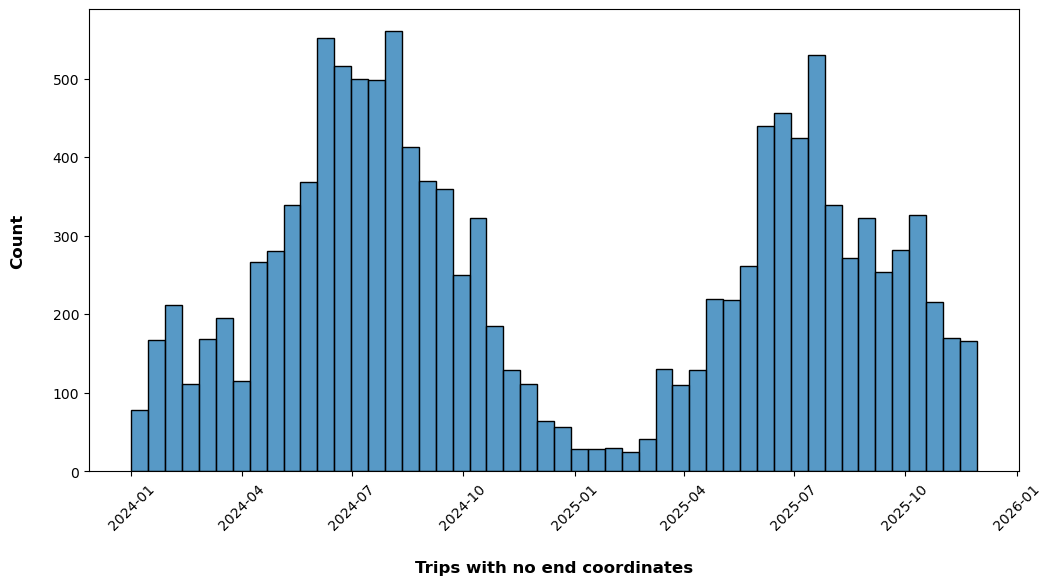

In [75]:
#the distribution of these classic bike rides with no recorded end coordinates matches that of all the data we have

fig, ax = plt.subplots(figsize=(12, 6))
sns.histplot(data = no_end_lat, x = 'started_at', bins = 50, ax = ax)
ax.tick_params(axis='x', labelrotation=45)
ax.set_xlabel("Trips with no end coordinates", labelpad=20, fontweight='bold', fontsize=12)
ax.set_ylabel("Count", labelpad=20, fontweight='bold', fontsize=12)
plt.show()

In [76]:
final_merged_trips['no_end_coords'] = final_merged_trips['end_lat'].isnull()

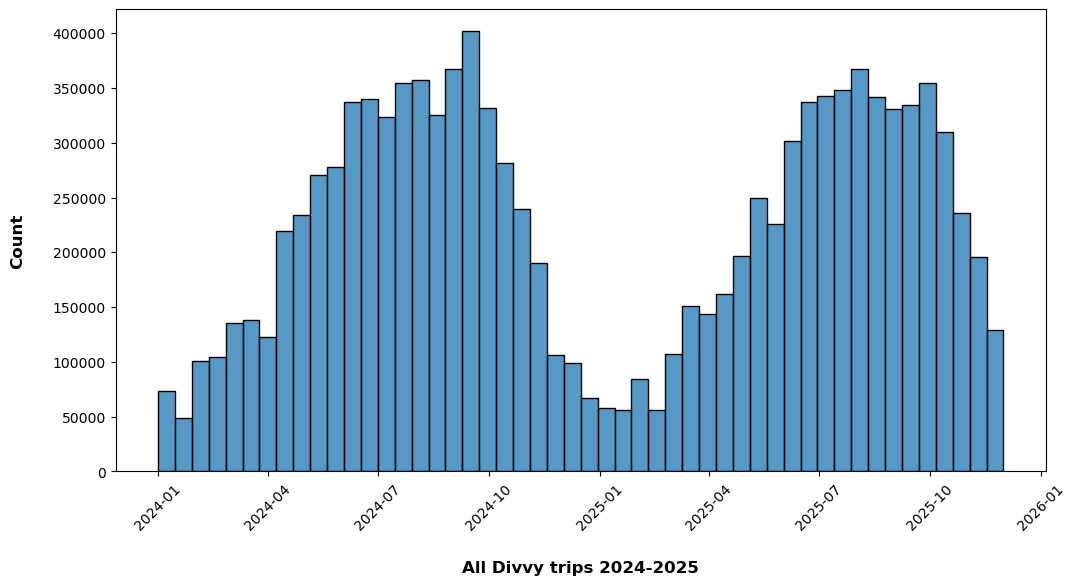

In [77]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.histplot(data = final_merged_trips, x = 'started_at', bins = 50, ax = ax)
ax.tick_params(axis='x', labelrotation=45)
ax.set_xlabel("All Divvy trips 2024-2025", labelpad=20, fontweight='bold', fontsize=12)
ax.set_ylabel("Count", labelpad=20, fontweight='bold', fontsize=12)
#plt.axvline(x= , color='red', linestyle='--')
plt.show()

Deleting these rows would delete only classic bike rides from our data. Leave it for now.

# 5. Final steps

Let's add some time features and basic weather data.

In [78]:
from pandas.tseries.holiday import USFederalHolidayCalendar

# Initialize the calendar
cal = USFederalHolidayCalendar()

# Generate a DatetimeIndex of holidays within a specific date range
holidays = cal.holidays(start='2024-01-01', end='2025-11-30')

print(holidays)

DatetimeIndex(['2024-01-01', '2024-01-15', '2024-02-19', '2024-05-27',
               '2024-06-19', '2024-07-04', '2024-09-02', '2024-10-14',
               '2024-11-11', '2024-11-28', '2024-12-25', '2025-01-01',
               '2025-01-20', '2025-02-17', '2025-05-26', '2025-06-19',
               '2025-07-04', '2025-09-01', '2025-10-13', '2025-11-11',
               '2025-11-27'],
              dtype='datetime64[ns]', freq=None)


In [79]:
final_merged_trips['start_hour'] = final_merged_trips['started_at'].dt.round('h')
final_merged_trips['start_day'] = final_merged_trips['started_at'].dt.round('D')
final_merged_trips['start_month'] = final_merged_trips['started_at'].dt.month
final_merged_trips['start_year'] = final_merged_trips['started_at'].dt.year
final_merged_trips['start_dayofweek'] = final_merged_trips['started_at'].dt.dayofweek
final_merged_trips['start_holiday'] = np.where(final_merged_trips['started_at'].isin(holidays), 1, 0)

In [80]:
final_merged_trips.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,end_station_name,start_lat,start_lng,end_lat,end_lng,...,end_id,start_coordinates,end_coordinates,no_end_coords,start_hour,start_day,start_month,start_year,start_dayofweek,start_holiday
0,6A9D809ABDF70617,electric_bike,2024-01-01 00:00:39,2024-01-01 00:07:56,<NA>,Clark St & Wrightwood Ave,41.95,-87.65,41.93,-87.643,...,"['TA1305000014', 'CHI00287']","(41.95, -87.65)","(41.93, -87.643)",False,2024-01-01,2024-01-01,1,2024,0,0
1,26B9F6E416A68EBA,electric_bike,2024-01-01 00:00:50,2024-01-01 00:04:20,<NA>,<NA>,41.9,-87.62,41.9,-87.62,...,<NA>,"(41.9, -87.62)","(41.9, -87.62)",False,2024-01-01,2024-01-01,1,2024,0,0
2,30EF016A0DF5ECEE,electric_bike,2024-01-01 00:00:52,2024-01-01 00:04:25,<NA>,<NA>,41.9,-87.62,41.9,-87.62,...,<NA>,"(41.9, -87.62)","(41.9, -87.62)",False,2024-01-01,2024-01-01,1,2024,0,0
3,0D9E85F804C85828,electric_bike,2024-01-01 00:00:53,2024-01-01 00:22:30,Clinton St & Madison St,<NA>,41.882,-87.641,41.89,-87.62,...,<NA>,"(41.882, -87.641)","(41.89, -87.62)",False,2024-01-01,2024-01-01,1,2024,0,0
4,56F5C3ED5178C131,classic_bike,2024-01-01 00:01:01,2024-01-01 00:24:12,LaSalle St & Illinois St,Indiana Ave & Roosevelt Rd,41.891,-87.632,41.868,-87.623,...,"['SL-005', 'CHI00450']","(41.891, -87.632)","(41.868, -87.623)",False,2024-01-01,2024-01-01,1,2024,0,0


In [81]:
final_merged_trips.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11272759 entries, 0 to 11272758
Data columns (total 22 columns):
 #   Column              Dtype         
---  ------              -----         
 0   ride_id             string        
 1   rideable_type       string        
 2   started_at          datetime64[ns]
 3   ended_at            datetime64[ns]
 4   start_station_name  string        
 5   end_station_name    string        
 6   start_lat           Float64       
 7   start_lng           Float64       
 8   end_lat             Float64       
 9   end_lng             Float64       
 10  member_casual       string        
 11  start_id            string        
 12  end_id              string        
 13  start_coordinates   object        
 14  end_coordinates     object        
 15  no_end_coords       bool          
 16  start_hour          datetime64[ns]
 17  start_day           datetime64[ns]
 18  start_month         int32         
 19  start_year          int32         
 20  

In [82]:
r = requests.get('https://www.ncei.noaa.gov//access/services/data/v1?dataset=daily-summaries&stations=USC00111577&startDate=2024-01-01&endDate=2025-12-25&format=json')

In [83]:
data = r.json()

In [84]:
weather = pd.DataFrame(data)

For now we use data from weather station USC00111577 located at the Chicago Midway Airport, available for free from the NCEI's API, but more comprehensive data sources can be added later.

In [85]:
weather.to_csv('data/raw/weather/stationUSC00111577.csv')

In [86]:
weather.head()

,DATE,STATION,SNOW,TMAX,TMIN,PRCP,TOBS,SNWD,WT01,WT06,WT11,WT03,WT05
0,2024-01-01,USC00111577,0,11,-17,0,-17,0,NaN,NaN,NaN,NaN,NaN
1,2024-01-02,USC00111577,0,50,-22,0,0,0,NaN,NaN,NaN,NaN,NaN
2,2024-01-03,USC00111577,0,28,0,0,17,0,1,1,NaN,NaN,NaN
3,2024-01-04,USC00111577,0,33,-22,0,0,0,NaN,NaN,NaN,NaN,NaN
4,2024-01-05,USC00111577,10,28,-22,8,0,0,NaN,NaN,NaN,NaN,NaN


In [87]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 725 entries, 0 to 724
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   DATE     725 non-null    object
 1   STATION  725 non-null    object
 2   SNOW     725 non-null    object
 3   TMAX     723 non-null    object
 4   TMIN     721 non-null    object
 5   PRCP     712 non-null    object
 6   TOBS     723 non-null    object
 7   SNWD     716 non-null    object
 8   WT01     186 non-null    object
 9   WT06     7 non-null      object
 10  WT11     21 non-null     object
 11  WT03     91 non-null     object
 12  WT05     4 non-null      object
dtypes: object(13)
memory usage: 73.8+ KB


In [88]:
weather = weather.convert_dtypes()
weather['DATE'] = pd.to_datetime(weather['DATE'])

In [89]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 725 entries, 0 to 724
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   DATE     725 non-null    datetime64[ns]
 1   STATION  725 non-null    string        
 2   SNOW     725 non-null    string        
 3   TMAX     723 non-null    string        
 4   TMIN     721 non-null    string        
 5   PRCP     712 non-null    string        
 6   TOBS     723 non-null    string        
 7   SNWD     716 non-null    string        
 8   WT01     186 non-null    string        
 9   WT06     7 non-null      string        
 10  WT11     21 non-null     string        
 11  WT03     91 non-null     string        
 12  WT05     4 non-null      string        
dtypes: datetime64[ns](1), string(12)
memory usage: 73.8 KB


Dropping some unnecessary columns:

In [90]:
weather.drop(columns=['TOBS', 'WT01', 'WT06', 'WT03', 'WT11', 'WT05'], axis = 1, inplace=True)

In [91]:
weather.head()

,DATE,STATION,SNOW,TMAX,TMIN,PRCP,SNWD
0,2024-01-01,USC00111577,0,11,-17,0,0
1,2024-01-02,USC00111577,0,50,-22,0,0
2,2024-01-03,USC00111577,0,28,0,0,0
3,2024-01-04,USC00111577,0,33,-22,0,0
4,2024-01-05,USC00111577,10,28,-22,8,0


Merging the weather data with the Divvy trips dataframe:

In [92]:
final_merged_trips['Date'] = final_merged_trips['started_at'].dt.floor('D')
final_merged_trips.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,end_station_name,start_lat,start_lng,end_lat,end_lng,...,start_coordinates,end_coordinates,no_end_coords,start_hour,start_day,start_month,start_year,start_dayofweek,start_holiday,Date
0,6A9D809ABDF70617,electric_bike,2024-01-01 00:00:39,2024-01-01 00:07:56,<NA>,Clark St & Wrightwood Ave,41.95,-87.65,41.93,-87.643,...,"(41.95, -87.65)","(41.93, -87.643)",False,2024-01-01,2024-01-01,1,2024,0,0,2024-01-01
1,26B9F6E416A68EBA,electric_bike,2024-01-01 00:00:50,2024-01-01 00:04:20,<NA>,<NA>,41.9,-87.62,41.9,-87.62,...,"(41.9, -87.62)","(41.9, -87.62)",False,2024-01-01,2024-01-01,1,2024,0,0,2024-01-01
2,30EF016A0DF5ECEE,electric_bike,2024-01-01 00:00:52,2024-01-01 00:04:25,<NA>,<NA>,41.9,-87.62,41.9,-87.62,...,"(41.9, -87.62)","(41.9, -87.62)",False,2024-01-01,2024-01-01,1,2024,0,0,2024-01-01
3,0D9E85F804C85828,electric_bike,2024-01-01 00:00:53,2024-01-01 00:22:30,Clinton St & Madison St,<NA>,41.882,-87.641,41.89,-87.62,...,"(41.882, -87.641)","(41.89, -87.62)",False,2024-01-01,2024-01-01,1,2024,0,0,2024-01-01
4,56F5C3ED5178C131,classic_bike,2024-01-01 00:01:01,2024-01-01 00:24:12,LaSalle St & Illinois St,Indiana Ave & Roosevelt Rd,41.891,-87.632,41.868,-87.623,...,"(41.891, -87.632)","(41.868, -87.623)",False,2024-01-01,2024-01-01,1,2024,0,0,2024-01-01


In [93]:
weather.rename(columns={'DATE': 'Date', 'STATION': 'Station'}, inplace=True)

In [94]:
weather.head()

,Date,Station,SNOW,TMAX,TMIN,PRCP,SNWD
0,2024-01-01,USC00111577,0,11,-17,0,0
1,2024-01-02,USC00111577,0,50,-22,0,0
2,2024-01-03,USC00111577,0,28,0,0,0
3,2024-01-04,USC00111577,0,33,-22,0,0
4,2024-01-05,USC00111577,10,28,-22,8,0


In [95]:
merged_final_df = pd.merge(final_merged_trips, weather, on='Date', how='left', validate = 'many_to_one')

In [96]:
merged_final_df.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,end_station_name,start_lat,start_lng,end_lat,end_lng,...,start_year,start_dayofweek,start_holiday,Date,Station,SNOW,TMAX,TMIN,PRCP,SNWD
0,6A9D809ABDF70617,electric_bike,2024-01-01 00:00:39,2024-01-01 00:07:56,<NA>,Clark St & Wrightwood Ave,41.95,-87.65,41.93,-87.643,...,2024,0,0,2024-01-01,USC00111577,0,11,-17,0,0
1,26B9F6E416A68EBA,electric_bike,2024-01-01 00:00:50,2024-01-01 00:04:20,<NA>,<NA>,41.9,-87.62,41.9,-87.62,...,2024,0,0,2024-01-01,USC00111577,0,11,-17,0,0
2,30EF016A0DF5ECEE,electric_bike,2024-01-01 00:00:52,2024-01-01 00:04:25,<NA>,<NA>,41.9,-87.62,41.9,-87.62,...,2024,0,0,2024-01-01,USC00111577,0,11,-17,0,0
3,0D9E85F804C85828,electric_bike,2024-01-01 00:00:53,2024-01-01 00:22:30,Clinton St & Madison St,<NA>,41.882,-87.641,41.89,-87.62,...,2024,0,0,2024-01-01,USC00111577,0,11,-17,0,0
4,56F5C3ED5178C131,classic_bike,2024-01-01 00:01:01,2024-01-01 00:24:12,LaSalle St & Illinois St,Indiana Ave & Roosevelt Rd,41.891,-87.632,41.868,-87.623,...,2024,0,0,2024-01-01,USC00111577,0,11,-17,0,0


In [97]:
merged_final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11272759 entries, 0 to 11272758
Data columns (total 29 columns):
 #   Column              Dtype         
---  ------              -----         
 0   ride_id             string        
 1   rideable_type       string        
 2   started_at          datetime64[ns]
 3   ended_at            datetime64[ns]
 4   start_station_name  string        
 5   end_station_name    string        
 6   start_lat           Float64       
 7   start_lng           Float64       
 8   end_lat             Float64       
 9   end_lng             Float64       
 10  member_casual       string        
 11  start_id            string        
 12  end_id              string        
 13  start_coordinates   object        
 14  end_coordinates     object        
 15  no_end_coords       bool          
 16  start_hour          datetime64[ns]
 17  start_day           datetime64[ns]
 18  start_month         int32         
 19  start_year          int32         
 20  

Let's add a trip duration column too just for the purpose of identifying more errors and doing some visualizations later.

In [98]:
merged_final_df['trip_duration'] = merged_final_df['ended_at'] - merged_final_df['started_at']
merged_final_df.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,end_station_name,start_lat,start_lng,end_lat,end_lng,...,start_dayofweek,start_holiday,Date,Station,SNOW,TMAX,TMIN,PRCP,SNWD,trip_duration
0,6A9D809ABDF70617,electric_bike,2024-01-01 00:00:39,2024-01-01 00:07:56,<NA>,Clark St & Wrightwood Ave,41.95,-87.65,41.93,-87.643,...,0,0,2024-01-01,USC00111577,0,11,-17,0,0,0 days 00:07:17
1,26B9F6E416A68EBA,electric_bike,2024-01-01 00:00:50,2024-01-01 00:04:20,<NA>,<NA>,41.9,-87.62,41.9,-87.62,...,0,0,2024-01-01,USC00111577,0,11,-17,0,0,0 days 00:03:30
2,30EF016A0DF5ECEE,electric_bike,2024-01-01 00:00:52,2024-01-01 00:04:25,<NA>,<NA>,41.9,-87.62,41.9,-87.62,...,0,0,2024-01-01,USC00111577,0,11,-17,0,0,0 days 00:03:33
3,0D9E85F804C85828,electric_bike,2024-01-01 00:00:53,2024-01-01 00:22:30,Clinton St & Madison St,<NA>,41.882,-87.641,41.89,-87.62,...,0,0,2024-01-01,USC00111577,0,11,-17,0,0,0 days 00:21:37
4,56F5C3ED5178C131,classic_bike,2024-01-01 00:01:01,2024-01-01 00:24:12,LaSalle St & Illinois St,Indiana Ave & Roosevelt Rd,41.891,-87.632,41.868,-87.623,...,0,0,2024-01-01,USC00111577,0,11,-17,0,0,0 days 00:23:11


In [99]:
negative_duration = merged_final_df[merged_final_df['trip_duration'] < '0 days 00:00:00']
negative_duration.head()
negative_duration.info()

<class 'pandas.core.frame.DataFrame'>
Index: 256 entries, 42525 to 10934406
Data columns (total 30 columns):
 #   Column              Non-Null Count  Dtype          
---  ------              --------------  -----          
 0   ride_id             256 non-null    string         
 1   rideable_type       256 non-null    string         
 2   started_at          256 non-null    datetime64[ns] 
 3   ended_at            256 non-null    datetime64[ns] 
 4   start_station_name  124 non-null    string         
 5   end_station_name    96 non-null     string         
 6   start_lat           256 non-null    Float64        
 7   start_lng           256 non-null    Float64        
 8   end_lat             256 non-null    Float64        
 9   end_lng             256 non-null    Float64        
 10  member_casual       256 non-null    string         
 11  start_id            124 non-null    string         
 12  end_id              96 non-null     string         
 13  start_coordinates   256 non-nul

There are 256 negative duration trips. Since July 2024, these errors are more rare and they seem to be associate with the end of Daylight Saving Time.

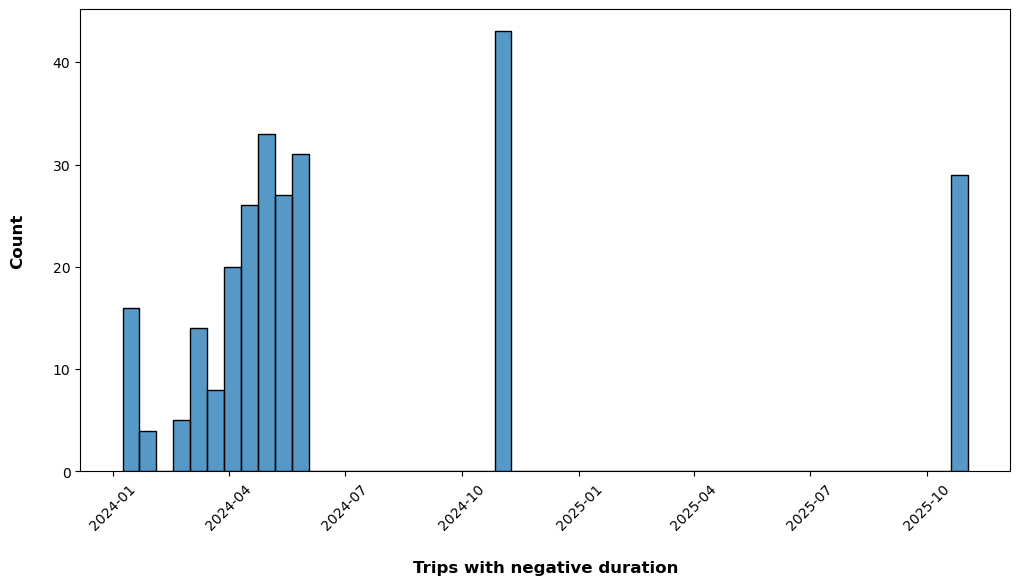

In [100]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.histplot(data = negative_duration, x = 'started_at', bins = 50, ax = ax)
ax.tick_params(axis='x', labelrotation=45)
ax.set_xlabel("Trips with negative duration", labelpad=20, fontweight='bold', fontsize=12)
ax.set_ylabel("Count", labelpad=20, fontweight='bold', fontsize=12)
plt.show()

In [101]:
zero_duration = merged_final_df[merged_final_df['trip_duration'] == '0 days 00:00:00']
zero_duration.head()
zero_duration.info()

<class 'pandas.core.frame.DataFrame'>
Index: 496 entries, 4176 to 1694033
Data columns (total 30 columns):
 #   Column              Non-Null Count  Dtype          
---  ------              --------------  -----          
 0   ride_id             496 non-null    string         
 1   rideable_type       496 non-null    string         
 2   started_at          496 non-null    datetime64[ns] 
 3   ended_at            496 non-null    datetime64[ns] 
 4   start_station_name  242 non-null    string         
 5   end_station_name    192 non-null    string         
 6   start_lat           496 non-null    Float64        
 7   start_lng           496 non-null    Float64        
 8   end_lat             496 non-null    Float64        
 9   end_lng             496 non-null    Float64        
 10  member_casual       496 non-null    string         
 11  start_id            242 non-null    string         
 12  end_id              192 non-null    string         
 13  start_coordinates   496 non-null 

There are also 496 trips of 0 duration. Given the tiny percentage of the data and the distribution of these weird values, we just drop them.

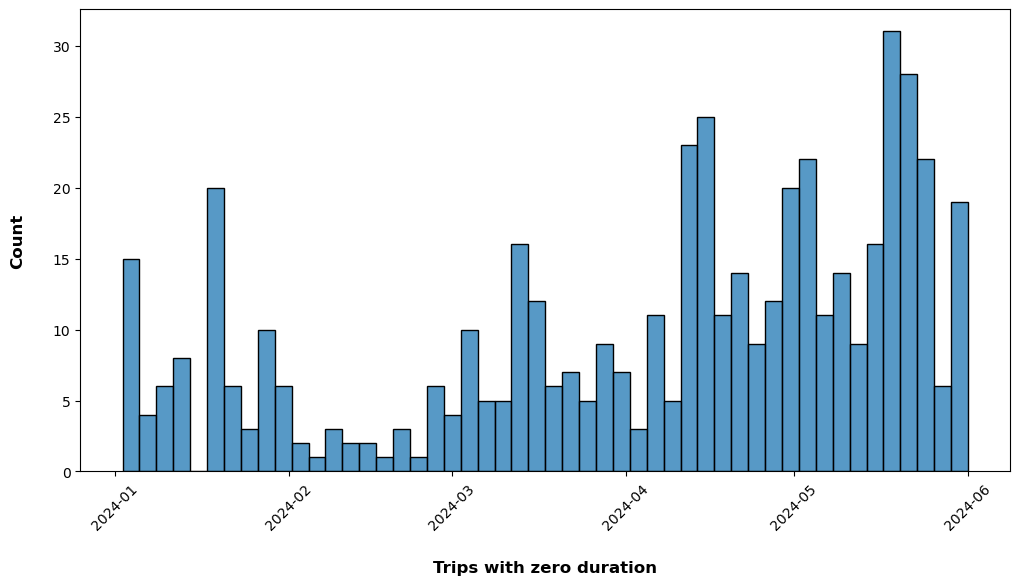

In [102]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.histplot(data = zero_duration, x = 'started_at', bins = 50, ax = ax)
ax.tick_params(axis='x', labelrotation=45)
ax.set_xlabel("Trips with zero duration", labelpad=20, fontweight='bold', fontsize=12)
ax.set_ylabel("Count", labelpad=20, fontweight='bold', fontsize=12)
plt.show()

In [103]:
merged_final_df = merged_final_df[merged_final_df['trip_duration'] > '0 days 00:00:00']

In [104]:
merged_final_df.describe()

,started_at,ended_at,start_lat,start_lng,end_lat,end_lng,start_hour,start_day,start_month,start_year,start_dayofweek,start_holiday,Date,trip_duration
count,11272007,11272007,11272007.0,11272007.0,11259402.0,11259402.0,11272007,11272007,1.127201e+07,1.127201e+07,1.127201e+07,1.127201e+07,11272007,11272007
mean,2025-01-08 10:05:24.218126848,2025-01-08 10:22:08.077623040,41.902931,-87.646349,41.903353,-87.646632,2025-01-08 10:05:24.698269440,2025-01-08 12:24:44.140595712,7.010253e+00,2.024480e+03,3.039199e+00,1.774307e-07,2025-01-07 19:33:42.985080320,0 days 00:16:43.859496449
min,2024-01-01 00:00:39,2024-01-01 00:04:20,41.64,-87.91,16.06,-144.05,2024-01-01 00:00:00,2024-01-01 00:00:00,1.000000e+00,2.024000e+03,0.000000e+00,0.000000e+00,2024-01-01 00:00:00,0 days 00:00:01
25%,2024-07-18 19:20:26.500000,2024-07-18 19:38:18.500000,41.881,-87.66,41.881,-87.66,2024-07-18 19:00:00,2024-07-19 00:00:00,5.000000e+00,2.024000e+03,1.000000e+00,0.000000e+00,2024-07-18 00:00:00,0 days 00:05:29
50%,2024-11-23 16:29:47,2024-11-23 16:44:59,41.898,-87.642,41.899,-87.643,2024-11-23 16:00:00,2024-11-24 00:00:00,7.000000e+00,2.024000e+03,3.000000e+00,0.000000e+00,2024-11-23 00:00:00,0 days 00:09:36
75%,2025-07-19 08:31:31,2025-07-19 08:53:41,41.93,-87.63,41.93,-87.63,2025-07-19 09:00:00,2025-07-19 00:00:00,9.000000e+00,2.025000e+03,5.000000e+00,0.000000e+00,2025-07-19 00:00:00,0 days 00:16:58
max,2025-11-30 23:51:43,2025-11-30 23:53:31,42.07,-87.52,87.96,152.53,2025-12-01 00:00:00,2025-12-01 00:00:00,1.200000e+01,2.025000e+03,6.000000e+00,1.000000e+00,2025-11-30 00:00:00,1 days 02:14:54
std,NaN,NaN,0.044625,0.027376,0.050864,0.084146,NaN,NaN,2.607842e+00,4.996062e-01,1.965213e+00,4.212252e-04,NaN,0 days 00:58:28.958986652


In [105]:
high_outliers = merged_final_df[merged_final_df['trip_duration'] >= '1 days 00:00:00']
high_outliers.describe()

,started_at,ended_at,start_lat,start_lng,end_lat,end_lng,start_hour,start_day,start_month,start_year,start_dayofweek,start_holiday,Date,trip_duration
count,13013,13013,13013.0,13013.0,580.0,580.0,13013,13013,13013.000000,13013.000000,13013.000000,13013.0,13013,13013
mean,2024-12-08 09:08:19.117805312,2024-12-09 10:07:37.396449792,41.889269,-87.64235,41.896676,-87.645774,2024-12-08 09:08:08.834242816,2024-12-08 11:45:46.822408192,6.716745,2024.419580,3.488281,0.0,2024-12-07 18:42:57.791439360,1 days 00:59:18.278644432
min,2024-01-01 00:28:08,2024-01-02 01:28:01,41.649,-87.837,41.692,-87.77,2024-01-01 00:00:00,2024-01-01 00:00:00,1.000000,2024.000000,0.000000,0.0,2024-01-01 00:00:00,1 days 00:00:38
25%,2024-06-21 18:25:48,2024-06-22 19:25:43,41.872,-87.655,41.871,-87.664,2024-06-21 18:00:00,2024-06-22 00:00:00,5.000000,2024.000000,2.000000,0.0,2024-06-21 00:00:00,1 days 00:59:40
50%,2024-09-29 08:09:12,2024-09-30 09:08:51,41.889,-87.634,41.894,-87.64,2024-09-29 08:00:00,2024-09-29 00:00:00,7.000000,2024.000000,4.000000,0.0,2024-09-29 00:00:00,1 days 00:59:51
75%,2025-06-29 14:27:10,2025-06-30 15:27:03,41.916,-87.624,41.93,-87.626,2025-06-29 14:00:00,2025-06-30 00:00:00,8.000000,2025.000000,5.000000,0.0,2025-06-29 00:00:00,1 days 00:59:54
max,2025-11-29 04:10:39,2025-11-30 05:10:24,42.065,-87.528,42.06,-87.53,2025-11-29 04:00:00,2025-11-29 00:00:00,12.000000,2025.000000,6.000000,0.0,2025-11-29 00:00:00,1 days 02:14:54
std,NaN,NaN,0.055574,0.033314,0.058912,0.030531,NaN,NaN,2.488954,0.493509,2.006052,0.0,NaN,0 days 00:05:37.326735891


In [106]:
low_outliers = merged_final_df[merged_final_df['trip_duration'] <= '0 days 00:00:03']
low_outliers.describe()

,started_at,ended_at,start_lat,start_lng,end_lat,end_lng,start_hour,start_day,start_month,start_year,start_dayofweek,start_holiday,Date,trip_duration
count,25676,25676,25676.0,25676.0,25676.0,25676.0,25676,25676,25676.000000,25676.000000,25676.000000,25676.0,25676,25676
mean,2025-01-18 21:29:14.260165120,2025-01-18 21:29:16.171327488,41.907158,-87.651908,41.907144,-87.651872,2025-01-18 21:29:22.844679680,2025-01-19 00:14:44.997662976,6.776679,2024.527535,3.120268,0.0,2025-01-18 06:34:12.656177152,0 days 00:00:01.911162174
min,2024-01-01 00:39:43,2024-01-01 00:39:45,41.654,-87.85,41.654,-87.85,2024-01-01 01:00:00,2024-01-01 00:00:00,1.000000,2024.000000,0.000000,0.0,2024-01-01 00:00:00,0 days 00:00:01
25%,2024-07-16 18:21:56.249999872,2024-07-16 18:21:59,41.883,-87.67,41.881,-87.67,2024-07-16 18:00:00,2024-07-17 00:00:00,5.000000,2024.000000,1.000000,0.0,2024-07-16 00:00:00,0 days 00:00:01
50%,2025-03-10 16:04:45,2025-03-10 16:04:47.500000,41.907,-87.65,41.908,-87.65,2025-03-10 16:00:00,2025-03-11 00:00:00,7.000000,2025.000000,3.000000,0.0,2025-03-10 00:00:00,0 days 00:00:02
75%,2025-07-21 14:17:06.500000,2025-07-21 14:17:08.500000,41.94,-87.63,41.94,-87.63,2025-07-21 14:15:00,2025-07-22 00:00:00,9.000000,2025.000000,5.000000,0.0,2025-07-21 00:00:00,0 days 00:00:02
max,2025-11-30 19:09:57,2025-11-30 19:10:00,42.07,-87.53,42.07,-87.53,2025-11-30 19:00:00,2025-12-01 00:00:00,12.000000,2025.000000,6.000000,0.0,2025-11-30 00:00:00,0 days 00:00:03
std,NaN,NaN,0.049166,0.031873,0.049178,0.031937,NaN,NaN,2.506478,0.499251,1.956953,0.0,NaN,0 days 00:00:00.714636544


There are 13013 very long (>1 day) rides and 25676 short (< 3 minutes) rides that could be errors or could represent real user behavior.

In [107]:
merged_final_df.drop(columns = ['Station', 'Date', 'no_end_coords', 'start_coordinates', 'end_coordinates'], inplace = True)

In [108]:
merged_final_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11272007 entries, 0 to 11272758
Data columns (total 25 columns):
 #   Column              Dtype          
---  ------              -----          
 0   ride_id             string         
 1   rideable_type       string         
 2   started_at          datetime64[ns] 
 3   ended_at            datetime64[ns] 
 4   start_station_name  string         
 5   end_station_name    string         
 6   start_lat           Float64        
 7   start_lng           Float64        
 8   end_lat             Float64        
 9   end_lng             Float64        
 10  member_casual       string         
 11  start_id            string         
 12  end_id              string         
 13  start_hour          datetime64[ns] 
 14  start_day           datetime64[ns] 
 15  start_month         int32          
 16  start_year          int32          
 17  start_dayofweek     int32          
 18  start_holiday       int64          
 19  SNOW                stri

Saving the dataframe for next steps:

In [109]:
#merged_final_df.to_csv('data/processed/divvy_data_cleaned.csv', index=False)

In [110]:
# Save the DataFrame as a pickle file in the current directory
file_path = 'data/processed/divvy_data_cleaned.pkl'
merged_final_df.to_pickle(file_path)

print(f"DataFrame successfully saved to {file_path}")

DataFrame successfully saved to data/processed/divvy_data_cleaned.pkl
